#Dog Breed Classifier
using ResNet50

##Import dataset from Kaggle

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"prudv1","key":"59b782ea7c8a976bc127d114ec48ccad"}'}

In [2]:
! mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 7.7MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=c8444a61e292860b7b68a026909ebe0b354518f37ee6a1623c5d480ae5b6cdef
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


In [3]:
!kaggle competitions download -c dog-breed-identification

 97% 667M/691M [00:05<00:00, 106MB/s]
100% 691M/691M [00:05<00:00, 142MB/s]


In [4]:
!unzip /content/dog-breed-identification.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: train/83fad0718581a696132c96c166472627.jpg  
  inflating: train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: train/840db91ba4600148f3dcb06ec419b421.jpg  
  inflating: train/840dbad5a691c22611d85b2488bf4cbb.jpg  
  inflating: train/8410ced9ebc1759a7ebce5c42bfb5222.jpg  
  inflating: train/84

In [5]:
!pip install git+https://github.com/ML-Challenge/learntools.git

  Cloning https://github.com/ML-Challenge/learntools.git to /tmp/pip-req-build-njutmv92
  Running command git clone -q https://github.com/ML-Challenge/learntools.git /tmp/pip-req-build-njutmv92
  Created wheel for learntools: filename=learntools-0.3.4-cp37-none-any.whl size=207296 sha256=b238ceed26335c164ab8d82959da148b5cb4780f8332d1cd17f344b7e794deb9
  Stored in directory: /tmp/pip-ephem-wheel-cache-l9r3pipd/wheels/80/69/91/11d580f9fabc3c94420a07ff947597bfd7a588e787187e4dfe
Successfully built learntools


##Import all libraries

In [6]:
import pandas as pd
import numpy as np
import os, shutil
from os.path import join
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Input, Dense
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.callbacks import Callback
from IPython.display import Image, display
from learntools.deep_learning.decode_predictions import decode_predictions
print(keras.__version__)

2.4.3


##Set up the dataset directory
Images corresponding to their breeds are moved into respective folders

In [7]:
df = pd.read_csv (r'labels.csv')
ids = df['id']
breeds = df['breed']
labels_dic = {}

# create a labels dictionary
for i, id in enumerate(ids):
    labels_dic[id] = breeds[i]

# create folders with label names
labels = ['beagle', 'chihuahua', 'doberman', 'french_bulldog', 'golden_retriever', 'malamute', 'pug', 'saint_bernard', 'scottish_deerhound', 'tibetan_mastiff'] #set(labels_dic.values()) 

os.mkdir('train/train')
# os.mkdir('test/test')
for label in labels:
    try:        
        os.mkdir('train/train/'+label)
        # os.mkdir('test/test/'+label)
    except OSError as error:  
        print(error) 

for id in labels_dic.keys():
    if labels_dic[id] in labels:
        # print(id)
        path = '/content/train/'
        train_source = path+id+'.jpg'
        train_destination = path+'train/'+labels_dic[id]+'/'+id+ '.jpg'
        try:
            shutil.move(train_source, train_destination)
        except:
            continue


In [8]:
!ls

dog-breed-identification.zip  labels.csv   sample_submission.csv  train
kaggle.json		      sample_data  test


## Global Variables

In [9]:
num_classes = 10 # Number of breeds that we are going to classify + other

image_resize = 224 # Since ResNet50 was built and trained using 224x224 images, we're going to resize our 300x300 images

batch_size_training = 100  # Training using batches of 100 images
batch_size_validation = 100  # Validation using batches of 100 images

## ImageDataGenerator Instance
Using ResNet50 preprocess_input to preprocess our images the same way the images used to train ResNet50 model were processed.

In [10]:
data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

## Load training images using flow_from_directory

In [11]:
train_generator = data_generator.flow_from_directory(
    'train/train',
    target_size=(image_resize, image_resize),
    batch_size=batch_size_training,
    class_mode='categorical')

Found 841 images belonging to 10 classes.


##Building the model

In [12]:
model = Sequential()

model.add(ResNet50(
    include_top=False,
    pooling='avg',
    weights='imagenet',
    ))

model.add(Dense(num_classes, activation='softmax'))
model.layers
model.layers[0].trainable = False
model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
Total params: 23,608,202
Trainable params: 20,490
Non-trainable params: 23,587,712
_________________________________________________________________


##Compile and fit the model

In [13]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
steps_per_epoch_training = len(train_generator)/ batch_size_training
# steps_per_epoch_validation = len(validation_generator)/ batch_size_validation
num_epochs = 20

In [15]:
# This callback function stopps training once the train accuracy hits 98%
class myCallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.98):
      print("\nReached 98% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [16]:
fit_history = model.fit(
    train_generator,
    # steps_per_epoch=steps_per_epoch_training,
    epochs=num_epochs,
    callbacks=[callbacks]
)

Epoch 1/20
9/9 [==============================] - 41s 504ms/step - loss: 2.2930 - accuracy: 0.2459
Epoch 2/20
9/9 [==============================] - 4s 472ms/step - loss: 0.7404 - accuracy: 0.8344
Epoch 3/20
9/9 [==============================] - 5s 478ms/step - loss: 0.3293 - accuracy: 0.9454
Epoch 4/20
9/9 [==============================] - 5s 478ms/step - loss: 0.1686 - accuracy: 0.9771
Epoch 5/20
9/9 [==============================] - 5s 472ms/step - loss: 0.1117 - accuracy: 0.9880

Reached 98% accuracy so cancelling training!


## Saving the model

In [21]:
model.save('dog_breed_classifier_resnet_model.h5')

## Prediction using model

In [18]:
def read_and_prep_images(img_paths, img_height=image_resize, img_width=image_resize):
    '''
    This function pre-processes all images before performing prediction
    '''
    imgs = [load_img(img_path, target_size=(img_height, img_width)) for img_path in img_paths]
    img_array = np.array([img_to_array(img) for img in imgs])
    output = preprocess_input(img_array)
    return(output)

In [19]:
test_img_dir = '/content/test/'
filenames = ['0a8d8dda0e354c0571c8d47600ab39a3.jpg', # pug
             '01b09dccd56851eadb6ac3f2add3c822.jpg', # beagle
             '0b5784f22b6f62ce04c6e1abb72b72a2.jpg', # chihuahua
             '001510bc8570bbeee98c8d80c8a95ec1.jpg', # pug
             '00c14d34a725db12068402e4ce714d4c.jpg'] # saint_bernard
img_paths = [join(test_img_dir, filename) for filename in filenames]

test_data = read_and_prep_images(img_paths)
preds = model.predict(test_data)
print(preds)
# most_likely_labels = decode_predictions(preds, top=3)

[[5.6161918e-03 4.9460256e-03 3.9199651e-03 1.7117608e-02 3.1475946e-03
  1.6890460e-03 9.5710510e-01 5.8435476e-03 3.5836114e-04 2.5663484e-04]
 [9.9556291e-01 3.4051944e-04 2.5401331e-04 1.4686163e-03 2.4386117e-04
  1.1150540e-04 9.4052323e-04 8.3397207e-04 1.5751334e-04 8.6598018e-05]
 [1.1502704e-01 4.9624842e-01 2.0842525e-01 1.6996215e-01 1.5058029e-03
  3.7257355e-03 3.5049815e-03 8.5828200e-05 4.2500105e-04 1.0898240e-03]
 [7.6579110e-04 4.2048017e-03 3.2844152e-02 1.1256385e-02 2.3052236e-03
  2.3393929e-03 6.2191683e-01 5.0523663e-03 1.2397321e-02 3.0691779e-01]
 [1.9236056e-02 3.4678524e-05 4.6504475e-04 2.1873745e-03 4.5738542e-03
  9.6316979e-04 3.4674096e-03 9.6657401e-01 7.2333627e-05 2.4259561e-03]]


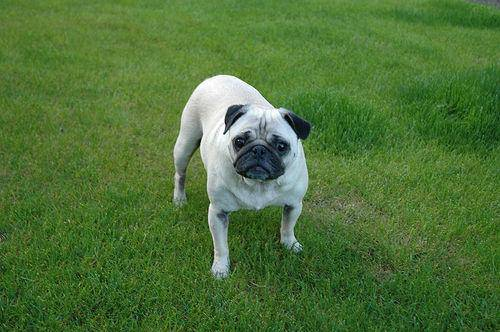

pug


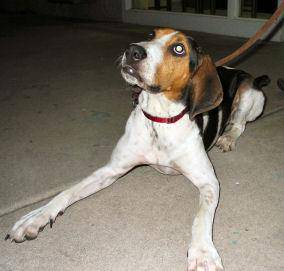

beagle


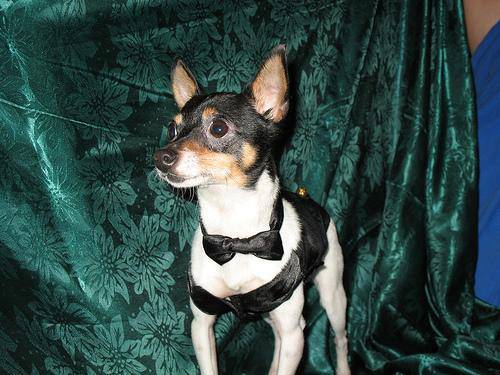

chihuahua


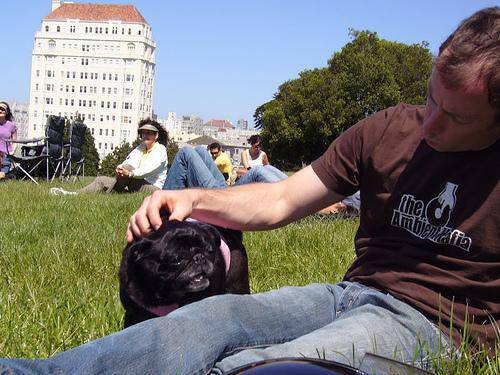

pug


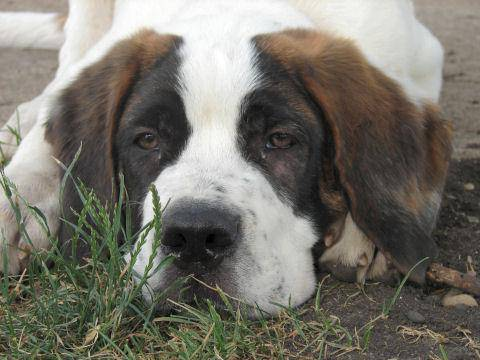

saint_bernard


In [20]:
# Displaying the images and their prediction
for i, img_path in enumerate(img_paths):
    display(Image(img_path))
    print(labels[np.argmax(preds[i])])